### Read in Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import VAR

from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


### Read in the data

In [19]:
df = pd.read_csv('../data/final_dfs/combined_final.csv', index_col='date')

In [20]:
df.head()

,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
date,,,,,,,,
2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [26]:
df['total'] = df.sum(axis=1)

In [29]:
df.reset_index(inplace=True)

In [31]:
df_final = df[['date', 'Coal', 'Nuclear', 'Solar', 'Wind', 'NGas', 'total']]

In [32]:
df_final

,date,Coal,Nuclear,Solar,Wind,NGas,total
0,2011-01-01,304483.898100,90516.910230,70.651290,123213.388200,248086.363990,1.537280e+06
1,2011-01-02,320703.672600,90462.214940,10.255158,62531.398440,268971.649980,1.490395e+06
2,2011-01-03,296436.223700,90472.370750,15.155827,89515.573520,222285.009850,1.402701e+06
3,2011-01-04,322214.637700,90312.687080,5.278214,59542.485700,271747.936850,1.492791e+06
4,2011-01-05,308136.080100,90280.191600,22.997359,128920.842500,358001.800050,1.775548e+06
...,...,...,...,...,...,...,...
3648,2020-12-27,184407.678785,122762.954790,29820.239198,321323.147861,194637.587100,1.708202e+06
3649,2020-12-28,193621.421107,122720.408975,19924.960198,350947.810220,216475.798107,1.809809e+06
3650,2020-12-29,144900.104532,122664.769337,11594.382815,443182.060206,167954.504264,1.783160e+06
3651,2020-12-30,158272.638521,122629.625647,3539.284392,434953.837358,227983.660971,1.897518e+06


In [37]:
df_final['date'] = pd.to_datetime(df_final['date'])


<ipython-input-37-9bc29418d562>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['date'] = pd.to_datetime(df_final['date'])


In [38]:
df_final.dtypes

date       datetime64[ns]
Coal              float64
Nuclear           float64
Solar             float64
Wind              float64
NGas              float64
total             float64
dtype: object

In [40]:
df_final['month']=df_final['date'].dt.month

<ipython-input-40-446969bfb729>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['month']=df_final['date'].dt.month


In [42]:
df_final.corr()

,Coal,Nuclear,Solar,Wind,NGas,total,month
Coal,1.000000,0.076350,-0.434996,-0.546764,0.218986,0.348926,-0.060283
Nuclear,0.076350,1.000000,0.119824,0.015332,0.240166,0.344377,0.027100
Solar,-0.434996,0.119824,1.000000,0.471638,0.341694,0.375293,0.052123
Wind,-0.546764,0.015332,0.471638,1.000000,-0.164116,0.137099,-0.028645
NGas,0.218986,0.240166,0.341694,-0.164116,1.000000,0.879085,0.027216
total,0.348926,0.344377,0.375293,0.137099,0.879085,1.000000,-0.014942
month,-0.060283,0.027100,0.052123,-0.028645,0.027216,-0.014942,1.000000


## VAR Time Series Models

In [23]:
# Code written by Joseph Nelson.
# Improved by Hovanes Gasparian

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

## Dickey-Fuller Tests on each Source

### Total

In [35]:
interpret_dftest(adfuller(df['total']))

Test Statistic    -3.656148
p-value            0.004774
Lag Used          29.000000
dtype: float64

In [81]:
interpret_dftest(adfuller(df['total'].diff(1).dropna()))

Test Statistic   -1.692813e+01
p-value           9.823692e-30
Lag Used          2.800000e+01
dtype: float64

In [82]:
df['first_diff_total'] = df['total'].diff(1)

### Biomass

In [24]:
interpret_dftest(adfuller(df['Biomass']))

Test Statistic   -7.435146e+00
p-value           6.211646e-11
Lag Used          2.400000e+01
dtype: float64

### Coal

In [25]:
interpret_dftest(adfuller(df['Coal']))

Test Statistic    -2.877402
p-value            0.048040
Lag Used          29.000000
dtype: float64

In [83]:
interpret_dftest(adfuller(df['Coal'].diff(1).dropna()))

Test Statistic   -1.802050e+01
p-value           2.696237e-30
Lag Used          2.400000e+01
dtype: float64

In [85]:
df['first_diff_coal'] = df['Coal'].diff(1)

### Gas

In [26]:
interpret_dftest(adfuller(df['NGas']))

Test Statistic    -4.165856
p-value            0.000752
Lag Used          24.000000
dtype: float64

In [79]:
interpret_dftest(adfuller(df['NGas'].diff(1).dropna()))

Test Statistic   -1.802050e+01
p-value           2.696237e-30
Lag Used          2.400000e+01
dtype: float64

In [87]:
df['first_diff_ngas'] = df['NGas'].diff(1)

### Hydro

In [28]:
interpret_dftest(adfuller(df['Hydro']))

Test Statistic    -4.377611
p-value            0.000325
Lag Used          30.000000
dtype: float64

### Nuclear

In [14]:
interpret_dftest(adfuller(df['Nuclear']))

Test Statistic   -2.949252
p-value           0.039913
Lag Used          3.000000
dtype: float64

In [88]:
interpret_dftest(adfuller(df['Nuclear'].diff(1).dropna()))

Test Statistic   -1.480475e+01
p-value           2.073387e-27
Lag Used          3.000000e+01
dtype: float64

In [89]:
df['first_diff_nuclear'] = df['Nuclear'].diff(1)

### Other

In [29]:
interpret_dftest(adfuller(df['Other']))

Test Statistic    -4.578738
p-value            0.000141
Lag Used          30.000000
dtype: float64

### Wind

In [30]:
interpret_dftest(adfuller(df['Wind']))

Test Statistic    -2.681855
p-value            0.077231
Lag Used          28.000000
dtype: float64

In [31]:
# Differenced 
interpret_dftest(adfuller(df['Wind'].diff(1).dropna()))

Test Statistic   -1.804267e+01
p-value           2.654696e-30
Lag Used          3.000000e+01
dtype: float64

#### Because we see a much lower p-value with the differenced data, let's save this column to our dataframe to use in our model

In [37]:
df['first_diff_wind'] = df['Wind'].diff(1)

### Solar

In [32]:
interpret_dftest(adfuller(df['Solar']))

Test Statistic    -1.083391
p-value            0.721650
Lag Used          28.000000
dtype: float64

In [75]:
interpret_dftest(adfuller(df['Solar'].diff(1).dropna()))

Test Statistic   -1.471495e+01
p-value           2.809432e-27
Lag Used          3.000000e+01
dtype: float64

In [76]:
df['first_diff_solar'] = df['Solar'].diff(1)

### Plot ACF & PACF

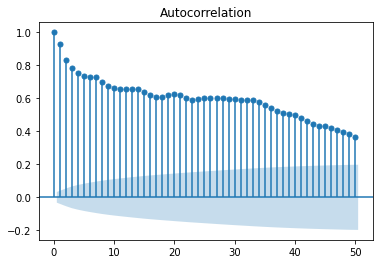

In [33]:
# plot the total electricity acf
plot_acf(df['total'], lags = 50);

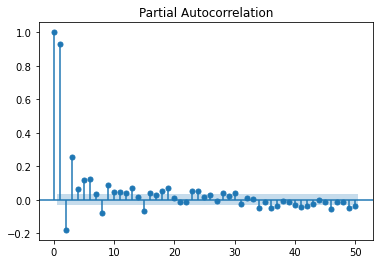

In [36]:
# plot the total electricity pacf
plot_pacf(df['total'], lags = 50);

### Modeling

In [91]:
# Subset our data
model_df = df[['first_diff_total', 'first_diff_ngas', 'first_diff_coal', 'first_diff_wind', 'first_diff_solar', 'first_diff_nuclear']].copy()

# Let's drop rows containing missing data
model_df.dropna(inplace = True)

In [92]:
train, test = train_test_split(model_df,
                              test_size = 0.10, 
                              shuffle=False)

In [93]:
train.head()

,first_diff_total,first_diff_ngas,first_diff_coal,first_diff_wind,first_diff_solar,first_diff_nuclear
date,,,,,,
2011-01-02,-23442.802983,20885.28599,16219.7745,-60681.98976,-60.396132,-54.69529
2011-01-03,-43846.875831,-46686.64013,-24267.4489,26984.17508,4.900669,10.15581
2011-01-04,45045.190080,49462.92700,25778.4140,-29973.08782,-9.877613,-159.68367
2011-01-05,141378.038755,86253.86320,-14078.5576,69378.35680,17.719145,-32.49548
2011-01-06,110739.930548,129772.98138,68316.4110,-87654.82550,43.006927,55.87253


In [94]:
var_model = VAR(train)

/Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [95]:
ts_model = var_model.fit(maxlags=5, ic='aic')

In [96]:
# What is the order of our autogressive model?
ts_model.k_ar

5

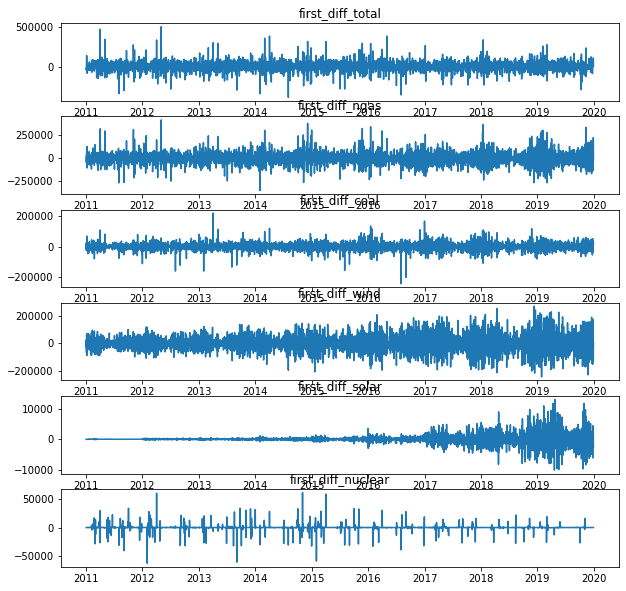

In [97]:
ts_model.plot();

<Figure size 1440x1440 with 0 Axes>

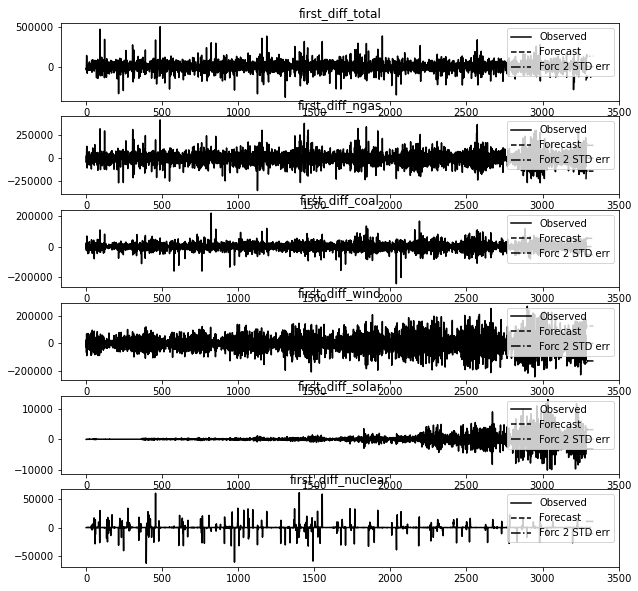

In [98]:
# plot the forecast looking 5 steps ahead
plt.figure(figsize=(20,20))
ts_model.plot_forecast(50);

### Evaluate our models (and forecasts, in possible)

In [99]:
forecast = ts_model.forecast(train.values, len(test))

In [100]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the first_diff_total data is: 3646963703.8777
The test MSE on the first_diff_ngas data is: 7318147209.5251
The test MSE on the first_diff_coal data is: 481133679.7592
The test MSE on the first_diff_wind data is: 9772181147.9876
The test MSE on the first_diff_solar data is: 54294441.1495
The test MSE on the first_diff_nuclear data is: 9935431.4502


In [101]:
# Loop through columns and get RMSE for each
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i], squared=False), 4)}')

The test RMSE on the first_diff_total data is: 60390.0961
The test RMSE on the first_diff_ngas data is: 85546.17
The test RMSE on the first_diff_coal data is: 21934.7596
The test RMSE on the first_diff_wind data is: 98854.3431
The test RMSE on the first_diff_solar data is: 7368.4762
The test RMSE on the first_diff_nuclear data is: 3152.0519


### Evaluate our models (and forecasts, in possible)

In [69]:
forecast = ts_model.forecast(train.values, len(test))

In [70]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the total data is: 29577405684.7134
The test MSE on the NGas data is: 23416882833.6194
The test MSE on the Coal data is: 6518154937.4332
The test MSE on the first_diff_wind data is: 9770433458.8709
The test MSE on the Solar data is: 422323163.5973
The test MSE on the Nuclear data is: 182154113.8146


In [71]:
# Loop through columns and get RMSE for each
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i], squared=False), 4)}')

The test RMSE on the total data is: 171980.8294
The test RMSE on the NGas data is: 153025.7587
The test RMSE on the Coal data is: 80735.0911
The test RMSE on the first_diff_wind data is: 98845.503
The test RMSE on the Solar data is: 20550.5028
The test RMSE on the Nuclear data is: 13496.4482


In [73]:
from autots import AutoTS

